In [2]:
import os

import numpy as np

import torch
from sfno.utils import get_num_params, get_seed
from sfno.pipeline import *
from sfno.datasets import *
from sfno.losses import *
from sfno.sfno import SFNO
from sfno.visualizations import plot_contour_trajectory
from torch.utils.data import DataLoader

get_seed(1127825, printout=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading modules for visualization - done in 0.526886 seconds. 



In [4]:
TRAIN_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "fnodata_extra_64x64_N1280_v1e-3_T50_steps100_alpha2.5_tau7.pt"
)

Ntrain = 1152
Ntest = 128

batch_size = 4

epochs = 10
learning_rate = 1e-2

n = 64
T = 10
T_out = 40
fs = "vorticity"

modes = 12
modes_t = 5
width = 20
beta = 1e-2


model_name = (
    f"sfno_ex2_fnodata_ep{epochs}"
    + f"_in{T}_out{T_out}"
    + f"_b{beta:.0e}.pt".replace("e-0", "e-").replace("e+0", "e")
)

path_model = os.path.join(MODEL_PATH, model_name)
print(model_name)


sfno_ex2_fnodata_ep10_in10_out40_b1e-2.pt


In [5]:
train_dataset = BochnerDataset(
    datapath=TRAIN_PATH,
    n_samples=Ntrain,
    steps=T,
    out_steps=T_out,
)
test_dataset = BochnerDataset(
    datapath=TEST_PATH, 
    n_samples=Ntest, 
    steps=T, 
    out_steps=T_out, 
    train=False
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta, 
             output_steps=T_out).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e3,
    final_div_factor=1e4,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)


9245131


In [7]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(train_loader) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(
                s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS
            )
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(
                    f"Epoch [{ep+1}/{epochs}] train rel L2: {l2.item():.4e}"
                )
                pbar.update(4)
    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model,
        l2diff,
        test_loader,
        device,
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [1/10] train rel L2: 4.1739e-02: 100%|██████████| 288/288 [00:07<00:00, 36.12it/s]



Epoch 1 |  Train L2: 9.71867e-02 | Test  L2: 4.41849e-02



Epoch [2/10] train rel L2: 3.0080e-02: 100%|██████████| 288/288 [00:07<00:00, 38.99it/s]



Epoch 2 |  Train L2: 3.11519e-02 | Test  L2: 3.13193e-02



Epoch [3/10] train rel L2: 2.5339e-02: 100%|██████████| 288/288 [00:07<00:00, 38.83it/s]



Epoch 3 |  Train L2: 2.58534e-02 | Test  L2: 2.23005e-02



Epoch [4/10] train rel L2: 1.9021e-02: 100%|██████████| 288/288 [00:07<00:00, 39.36it/s]



Epoch 4 |  Train L2: 2.06010e-02 | Test  L2: 2.06191e-02



Epoch [5/10] train rel L2: 1.5935e-02: 100%|██████████| 288/288 [00:07<00:00, 39.31it/s]



Epoch 5 |  Train L2: 1.85130e-02 | Test  L2: 1.81605e-02



Epoch [6/10] train rel L2: 1.4221e-02: 100%|██████████| 288/288 [00:07<00:00, 39.64it/s]



Epoch 6 |  Train L2: 1.64777e-02 | Test  L2: 1.46251e-02



Epoch [7/10] train rel L2: 1.2833e-02: 100%|██████████| 288/288 [00:07<00:00, 39.17it/s]



Epoch 7 |  Train L2: 1.38583e-02 | Test  L2: 1.34636e-02



Epoch [8/10] train rel L2: 1.1006e-02: 100%|██████████| 288/288 [00:07<00:00, 38.96it/s]



Epoch 8 |  Train L2: 1.20239e-02 | Test  L2: 1.16431e-02



Epoch [9/10] train rel L2: 1.1223e-02: 100%|██████████| 288/288 [00:07<00:00, 38.49it/s]



Epoch 9 |  Train L2: 1.10008e-02 | Test  L2: 1.11290e-02



Epoch [10/10] train rel L2: 1.0350e-02: 100%|██████████| 288/288 [00:07<00:00, 39.53it/s]



Epoch 10 |  Train L2: 1.05725e-02 | Test  L2: 1.08691e-02



In [10]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)
model.load_state_dict(torch.load(path_model))
preds = []
gt_solns = []
test_l2_all = []
test_dataset = BochnerDataset(
    datapath=TEST_PATH, 
    n_samples=Ntest, 
    steps=T, 
    out_steps=T_out, 
    T_start=30,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x[fs].to(device), y[fs].to(device)
        out = model(x, out_steps=T_out)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(np.mean(test_l2_all))


0.01054863885656232


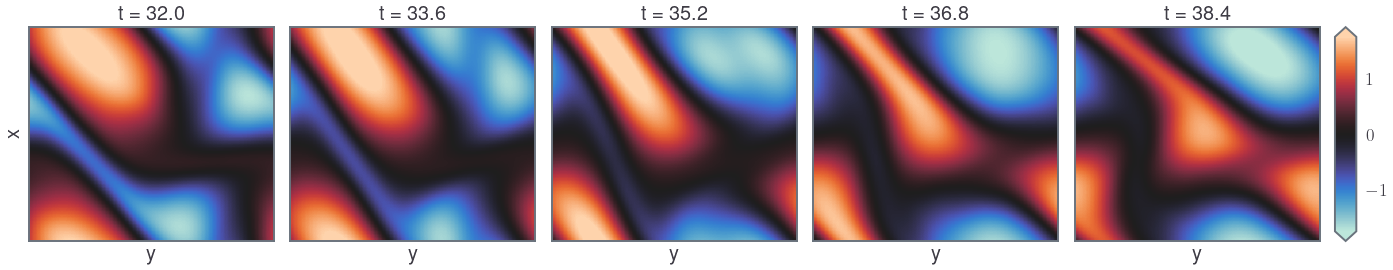

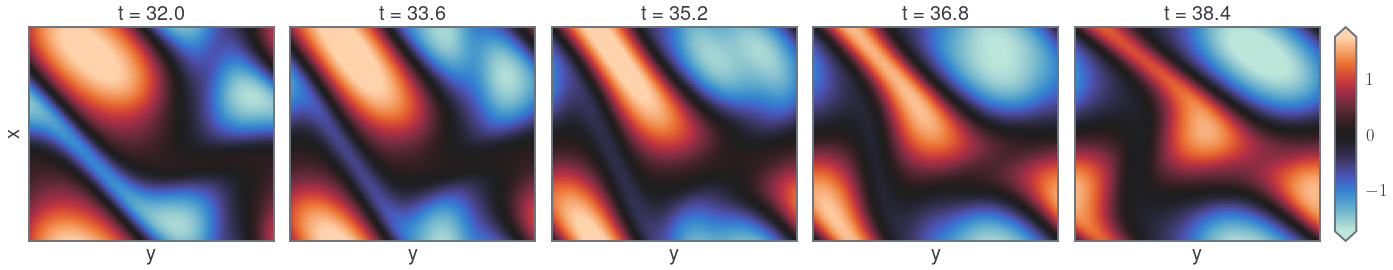

In [12]:
idx = np.random.randint(0, Ntest)
plot_contour_trajectory(preds[idx], num_snapshots=5, T_start=30+10*0.2, dt=0.2)
plot_contour_trajectory(gt_solns[idx], num_snapshots=5, T_start=30+10*0.2, dt=0.2)
